<a href="https://www.kaggle.com/code/mohamedbakrey/make-a-classification-for-bbc-news-by-lstm?scriptVersionId=99714259" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Loading the libraries

In [104]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

['learn-ai-bbc']


# Read The data

In [45]:
df=pd.read_csv('../input/learn-ai-bbc/BBC News Train.csv')
print("Shpe of Data",df.shape)
df.head(10)

Shpe of Data (1490, 3)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


Text(0.5, 1.0, 'The Distribution of Category')

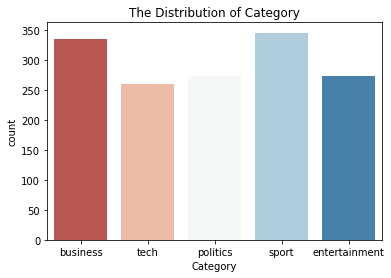

In [47]:
print(df['Category'].value_counts())
sns.countplot(data = df, x = "Category", palette = "RdBu")
plt.title("The Distribution of Category")

In [48]:
# Show the describe include object 
df.describe(include = 'object')

,Text,Category
count,1490,1490
unique,1440,5
top,microsoft seeking spyware trojan microsoft is ...,sport
freq,2,346


# EDA

### Lets calculate the length of Text

In [49]:
# Lets calculate the length of the Reviews
df['length'] = df['Text'].apply(len)

(array([919., 482.,  76.,   6.,   3.,   1.,   0.,   2.,   0.,   1.]),
 array([  501. ,  2289.6,  4078.2,  5866.8,  7655.4,  9444. , 11232.6,
        13021.2, 14809.8, 16598.4, 18387. ]),
 <BarContainer object of 10 artists>)

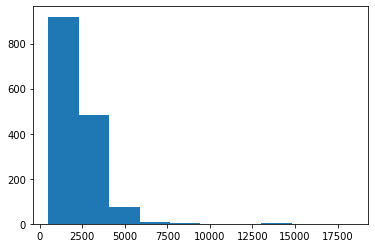

In [51]:
plt.hist(x=df['length'])

## Text Polarity

In [54]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df['polarity'] = df['Text'].apply(get_polarity)

### Text Subjectivity

In [55]:
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df['subjectivity'] = df['Text'].apply(get_subjectivity)

In [61]:
## lets summarize the Newly Created Features
df[['length','polarity','Text']]

,length,polarity,Text
0,1866,0.023320,worldcom ex-boss launches defence lawyers defe...
1,2016,0.077917,german business confidence slides german busin...
2,3104,0.077754,bbc poll indicates economic gloom citizens in ...
3,3618,0.156109,lifestyle governs mobile choice faster bett...
4,2190,0.009685,enron bosses in $168m payout eighteen former e...
...,...,...,...
1485,1266,0.107292,double eviction from big brother model caprice...
1486,3111,0.221375,dj double act revamp chart show dj duo jk and ...
1487,1370,0.066856,weak dollar hits reuters revenues at media gro...
1488,3242,0.203186,apple ipod family expands market apple has exp...


In [63]:
## lets summarize the Newly Created Features
df[['length','polarity','subjectivity']]

,length,polarity,subjectivity
0,1866,0.023320,0.395125
1,2016,0.077917,0.353854
2,3104,0.077754,0.390688
3,3618,0.156109,0.478536
4,2190,0.009685,0.342117
...,...,...,...
1485,1266,0.107292,0.340278
1486,3111,0.221375,0.458355
1487,1370,0.066856,0.417992
1488,3242,0.203186,0.427091


## Visualizing Polarity and Subjectivity

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


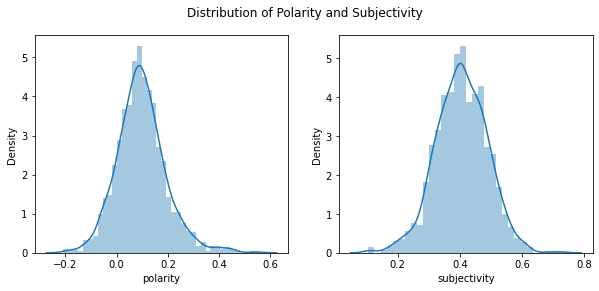

In [64]:
## Visualizing Polarity and Subjectivity

plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(df['polarity'])

plt.subplot(1, 2, 2)
sns.distplot(df['subjectivity'])

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


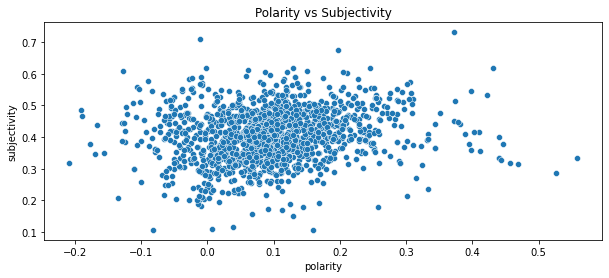

In [65]:
# lets check relation between Polarity and Subjectivity

sns.scatterplot(df['polarity'], df['subjectivity'])
plt.title('Polarity vs Subjectivity')
plt.show()

<AxesSubplot:>

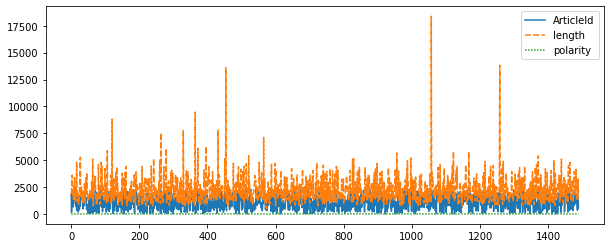

In [66]:
sns.lineplot(data=df.drop(['subjectivity'], axis=1))

<AxesSubplot:>

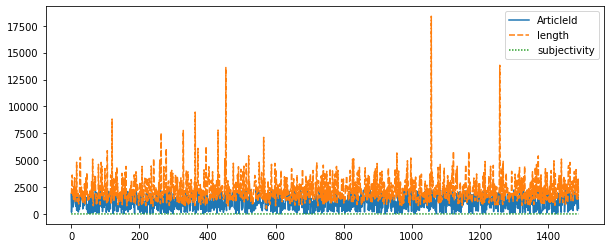

In [67]:
sns.lineplot(data=df.drop(['polarity'], axis=1))

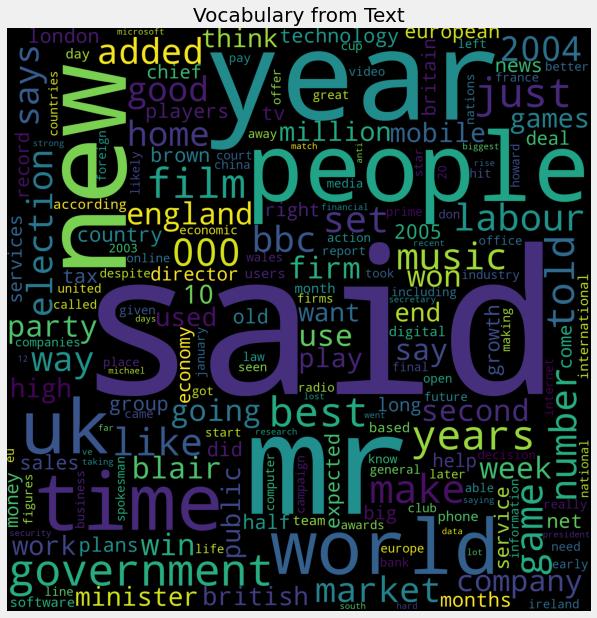

In [74]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df['Text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Text", fontsize = 20)
plt.show()

# Using Feature Extraction

In [82]:
df['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [90]:
#I do aspire here to have balanced classes
num_of_categories = 45000
shuffled = df.reindex(np.random.permutation(df.index))
sport    = shuffled[shuffled['Category'] == 'sport'][:num_of_categories]
business = shuffled[shuffled['Category'] == 'business'][:num_of_categories]
politics = shuffled[shuffled['Category'] == 'politics'][:num_of_categories]
entertainment = shuffled[shuffled['Category'] == 'entertainment'][:num_of_categories]
tech = shuffled[shuffled['Category'] == 'tech'][:num_of_categories]
concated = pd.concat([sport,business,politics,entertainment,tech], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [92]:
#One-hot encode the lab
concated.loc[concated['Category'] == 'sport', 'LABEL'] = 0
concated.loc[concated['Category'] == 'business', 'LABEL'] = 1
concated.loc[concated['Category'] == 'politics', 'LABEL'] = 2
concated.loc[concated['Category'] == 'entertainment', 'LABEL'] = 3
concated.loc[concated['Category'] == 'tech', 'LABEL'] = 4
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=5)
print(labels[:10])
if 'Category' in concated.keys():
    concated.drop(['Category'], axis=1)
'''
 [1. 0. 0. 0.] e
 [0. 1. 0. 0.] b
 [0. 0. 1. 0.] t
 [0. 0. 0. 1.] m
'''

1002    3
579     1
389     1
1166    3
1139    3
277     0
1064    3
86      0
601     1
405     1
Name: LABEL, dtype: int64
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


'\n [1. 0. 0. 0.] e\n [0. 1. 0. 0.] b\n [0. 0. 1. 0.] t\n [0. 0. 0. 1.] m\n'

In [99]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['Text'].values)
sequences = tokenizer.texts_to_sequences(concated['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 24983 unique tokens.


In [102]:
print ("Shape of X:",len(X))

Shape of X: 1490


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [114]:
epochs = 50
emb_dim = 128
batch_size = 64
labels[:2]

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

# Using Model LSTM

In [115]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation='softmax'))

((1117, 130), (1117, 5), (373, 130), (373, 5))


In [116]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [117]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 1,073,733
Trainable params: 1,073,733
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.01)])

Epoch 1/50
14/14 [==============================] - 7s 485ms/step - loss: 0.2889 - acc: 0.9082 - val_loss: 0.5509 - val_acc: 0.8348
Epoch 2/50
14/14 [==============================] - 7s 535ms/step - loss: 0.2531 - acc: 0.9160 - val_loss: 0.6887 - val_acc: 0.8348
Epoch 3/50
14/14 [==============================] - 7s 480ms/step - loss: 0.2614 - acc: 0.9048 - val_loss: 0.5460 - val_acc: 0.8125
Epoch 4/50
14/14 [==============================] - 7s 479ms/step - loss: 0.2265 - acc: 0.9406 - val_loss: 0.6569 - val_acc: 0.8482
Epoch 5/50
14/14 [==============================] - 7s 477ms/step - loss: 0.2081 - acc: 0.9373 - val_loss: 0.7269 - val_acc: 0.8348
Epoch 6/50
14/14 [==============================] - 7s 536ms/step - loss: 0.2417 - acc: 0.9429 - val_loss: 0.4929 - val_acc: 0.8527
Epoch 7/50
14/14 [==============================] - 7s 476ms/step - loss: 0.1929 - acc: 0.9418 - val_loss: 0.5872 - val_acc: 0.8348
Epoch 8/50
14/14 [==============================] - 7s 489ms/step - loss: 0.

In [120]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12/12 [==============================] - 1s 88ms/step - loss: 0.4643 - acc: 0.8847
Test set
  Loss: 0.464
  Accuracy: 0.885


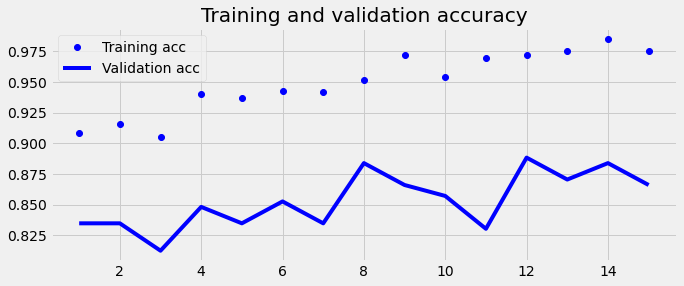

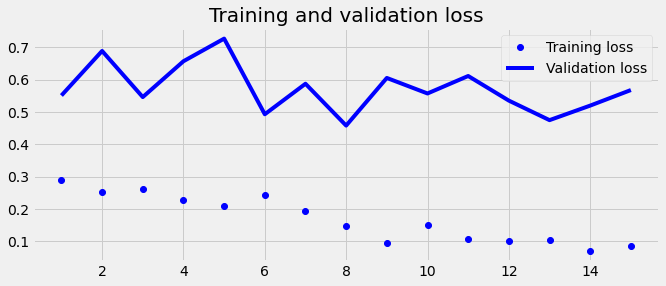

In [121]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Make Predection 

In [123]:
txt = ["wales silent on grand slam talk rhys williams "]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['sport','business','politics','entertainment','tech']
print(pred, labels[np.argmax(pred)])

[[9.99448597e-01 1.11196656e-04 1.42625477e-05 3.95577634e-04
  3.03387405e-05]] sport
